# Logs
 - add num of conv2d layers and depth(get many big and blue pixels) change depth,better
 - delete dropout
 -wrap with control dependencies, 
 ### why I have to feed real-input to generator opt while using control-dependencies? (much more fast to begin generate image like face), then change lr to 0.0002,looks great!
 - use guassin distribution for sampling, not better than uniform
 - use SGD for discriminator and adam for the other   no obviously improvement
 -use more soft labels, real(0.8~1.2) fake(0.1)  
 -change alpha to 0.1
 
 ## better but maybe more?

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

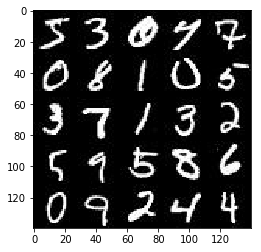

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

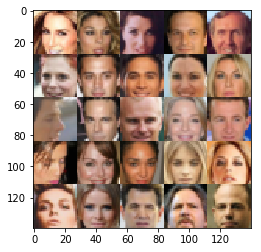

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_height,image_width,image_channels),name='real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    lr_rate = tf.placeholder(tf.float32,name='lr_rate') 
    
    
    return real_input, z_input, lr_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.05
    with tf.variable_scope('discriminator',reuse=reuse):
        #input_shape is 28*28*3
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1*alpha,x1)
#         drop1 = tf.nn.dropout(relu1,0.7)
        #14*14*64
        x2 = tf.layers.conv2d(x1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(x2*alpha,x2)
#         drop2 = tf.nn.dropout(relu2,0.7)
        #14*14*128
        x3 = tf.layers.conv2d(x2,256,3,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.maximum(x3*alpha,x3)
#         drop3 = tf.nn.dropout(relu3,0.7)
        
        x4 = tf.layers.conv2d(x3,512,3,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4,training=True)
        x4 = tf.maximum(x4*alpha,x4)
        
#         x4 = tf.layers.conv2d(x4,512,3,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x4 = tf.layers.batch_normalization(x4,training=True)
#         x4 = tf.maximum(x4*alpha,x4)
#         x4 = tf.nn.dropout(x4,0.9)
        
        #14*14*256
        flatten = tf.reshape(x4,(-1,7*7*512))
        logits = tf.layers.dense(flatten,1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.05
    with tf.variable_scope('generator',reuse=not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(x1*alpha,x1)
        
        x2 = tf.layers.conv2d_transpose(x1,512,3,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(x2*alpha,x2)
        x2 = tf.nn.dropout(x2,0.5)
#         x2 = tf.layers.conv2d_transpose(x2,512,3,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x2 = tf.layers.batch_normalization(x2,training=is_train)
#         x2 = tf.maximum(x2*alpha,x2)
#         x2 = tf.nn.dropout(x2,0.5)
        x2 = tf.layers.conv2d_transpose(x2,256,3,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(x2*alpha,x2)
        x2 = tf.nn.dropout(x2,0.5)
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(x3*alpha,x3)
        x3 = tf.nn.dropout(x3,0.5)
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=2,padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())

        output = tf.tanh(logits)
        
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_real)*np.random.randint(9,12)*0.1,
                                                                         logits=d_logits_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake)*0.05,logits=d_logits_fake))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_logits_fake)*np.random.randint(9,12)*0.1,logits=d_logits_fake))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    global_step = tf.Variable(0,trainable=False)
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    decayed_lr = tf.train.exponential_decay(learning_rate,global_step,10000,0.98,staircase=True,name='decay')
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=decayed_lr,beta1=beta1).minimize(
                                                                            d_loss,var_list=d_vars,global_step=global_step)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=decayed_lr,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
#     example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    example_z = np.random.normal(0, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    real_input,z_input,lr_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss = model_loss(real_input,z_input,data_shape[-1])
    d_opt,g_opt = model_opt(d_loss,g_loss,learning_rate,beta1)
    

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                
#                 batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                batch_z = np.random.normal(0, 1, size=[batch_size, z_dim])
                train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images*2})
                train_loss_g = g_loss.eval({z_input: batch_z})
                if train_loss_d<1:
                    _ = sess.run(g_opt,{z_input:batch_z,lr_rate:learning_rate,real_input:batch_images*2})
                else:
                    _ = sess.run(d_opt,{z_input:batch_z,lr_rate:learning_rate,real_input:batch_images*2})
        
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 200 == 0:
                    show_generator_output(sess,25,z_input,data_shape[-1],data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/1... Discriminator Loss: 3.2560... Generator Loss: 21.9775


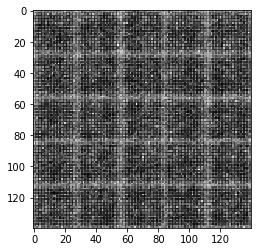

Epoch 1/1... Discriminator Loss: -1.1348... Generator Loss: 4.8403


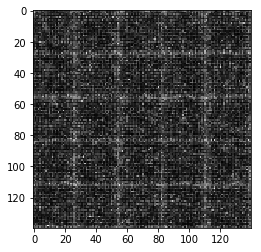

Epoch 1/1... Discriminator Loss: -1.0271... Generator Loss: 3.4714


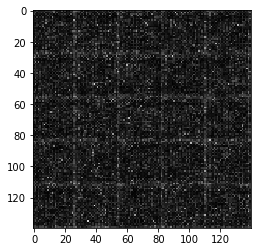

Epoch 1/1... Discriminator Loss: 0.1431... Generator Loss: 6.5573


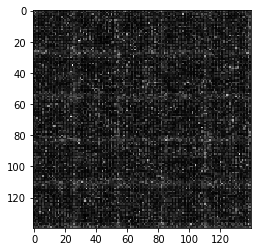

Epoch 1/1... Discriminator Loss: 2.0000... Generator Loss: 0.7604


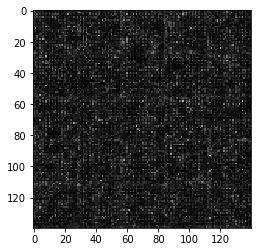

Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.3500


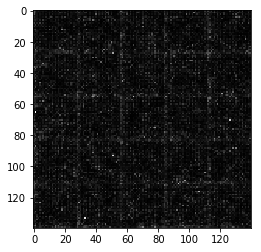

Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 6.7367


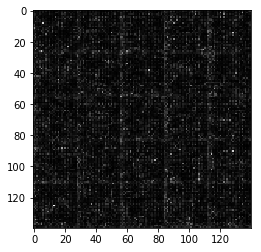

Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 8.4412


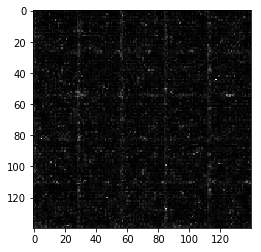

Epoch 1/1... Discriminator Loss: 0.1644... Generator Loss: 3.5052


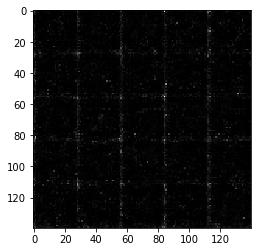

Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 7.7773


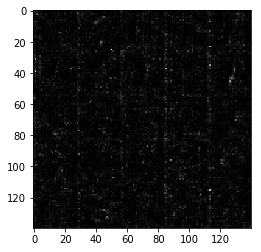

Epoch 1/1... Discriminator Loss: -0.0029... Generator Loss: 2.3585


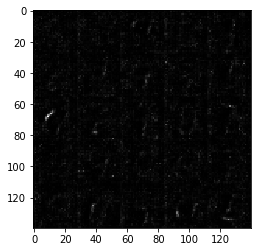

Epoch 1/1... Discriminator Loss: 0.2534... Generator Loss: 1.9602


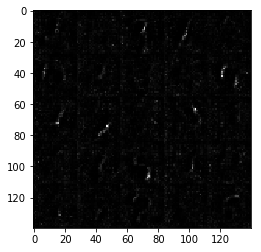

Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 0.9803


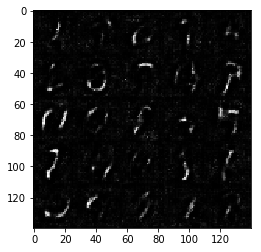

Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 0.8869


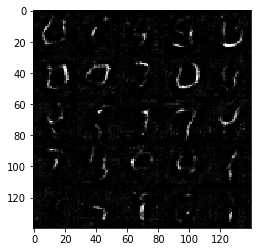

Epoch 1/1... Discriminator Loss: 0.3154... Generator Loss: 4.3634


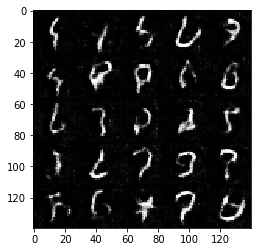

Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.3002


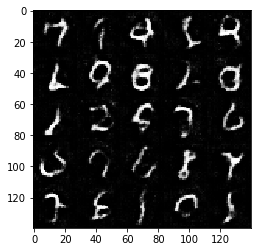

Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 2.4797


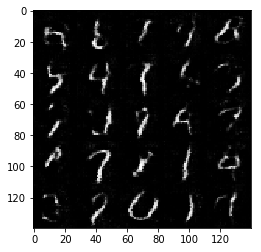

Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.9759


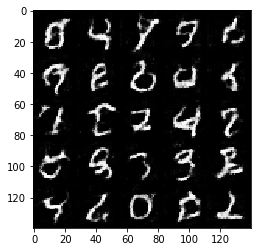

Epoch 1/1... Discriminator Loss: 0.2810... Generator Loss: 1.4377


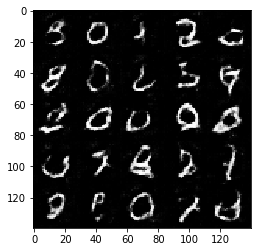

Epoch 1/1... Discriminator Loss: -0.0924... Generator Loss: 2.3221


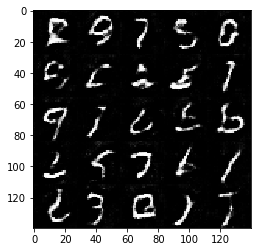

KeyboardInterrupt: 

In [106]:

batch_size = 64
z_dim = 100
learning_rate = 0.0002

beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.3420
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.5702
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 5.1529
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.7668
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 3.1484
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 3.3428
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 4.5410
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 2.1718
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 6.9486


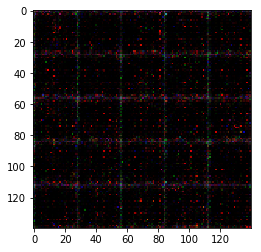

Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 3.7977
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 2.3586
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 4.9072
Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 2.8989
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 4.3144
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 3.2771
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 4.3432
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 5.3764


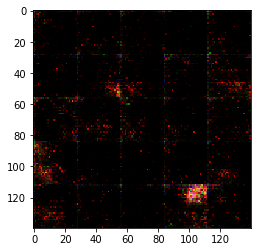

Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 2.2244
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 2.5180
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 2.5511
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 5.1177
Epoch 1/1... Discriminator Loss: 0.7070... Generator Loss: 4.1749
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 5.3021
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 3.3499
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 3.0675


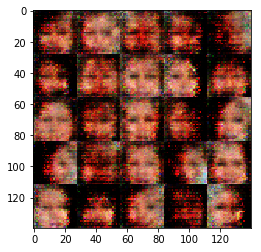

Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 2.3170
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 5.6043
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 2.9497
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 2.8678
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 2.4786
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 2.3857... Generator Loss: 5.2036
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 1.4611


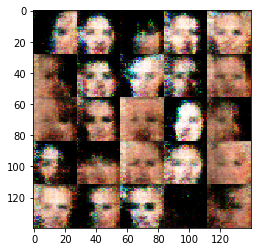

Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.3151
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 2.5181
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 2.1763
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 3.4550
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.4450


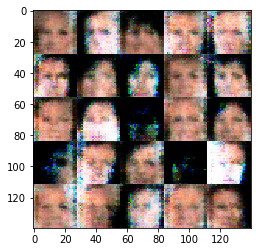

Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.9764
Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 3.4459
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.9327
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 2.7339
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.5966
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 2.7645
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.6870
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 3.9358
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 3.0218
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 2.1333


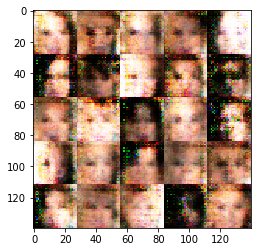

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 2.5706
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 4.7108
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 3.3469
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 2.3349
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.8110
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.7523
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 3.2975
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.8393


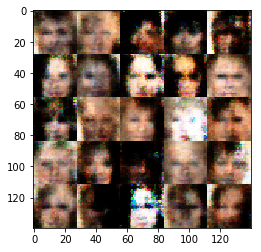

Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 2.1753
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 2.8167
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.8322
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.7995
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.7014
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 3.8735
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 2.2810
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 2.9200


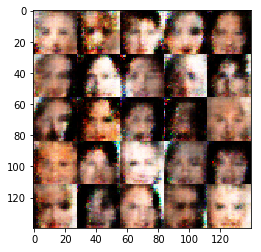

Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 2.6441
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.9021
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 3.7588
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 3.7164
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 2.8215
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.4403
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.2009


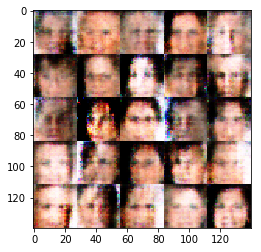

Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.9824
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 2.0982
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.6666
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 3.1534
Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 3.2298
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 2.5460
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.8604
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.9020


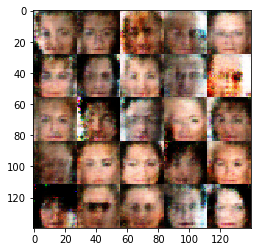

Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 3.7433
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 3.5792
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.4525
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.9597
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 3.9044
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.6005


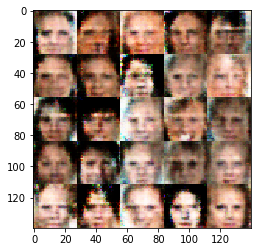

Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 2.8911
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 3.2870
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 3.0972
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 2.1217
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.8290
Epoch 1/1... Discriminator Loss: 1.7251... Generator Loss: 3.3755
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 2.0807
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 3.4792


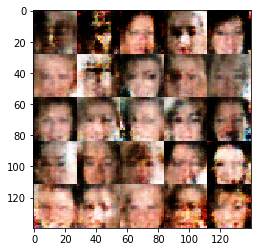

Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 2.4504
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 2.6884
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.7408
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 2.8533
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.8337
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 2.9966
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.8923


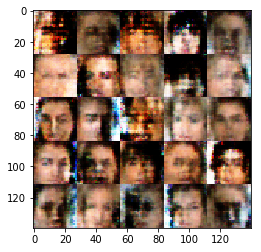

Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 2.7189
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 2.9071
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.3741
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.5802
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.8176
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 2.7673


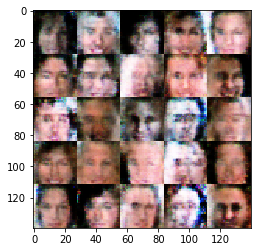

Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.7118
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 1.5166
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 2.4229
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.9831
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 2.2630
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 2.6114
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 4.2338
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.4316


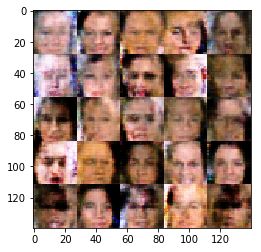

Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 2.9292
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.9492
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 1.8977
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 2.2076
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 3.0282
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 3.3857
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 2.0948
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 2.4627


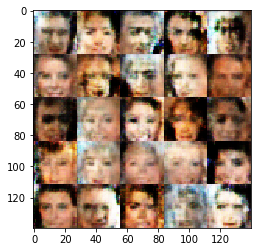

Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.8455
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 2.4476
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 2.1537
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.8558
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 2.6324
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.8086
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.5484


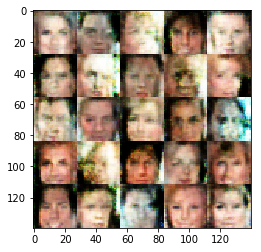

Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.5305
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.5717
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 2.5213
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.8911
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.9020
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 2.9660
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.9909
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.7932
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 2.6093


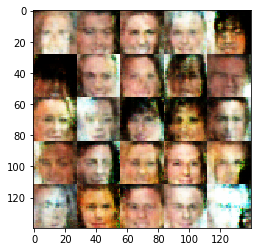

Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 2.2496
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 2.2486
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.5774
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.9308
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 2.3307
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 2.5342
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 4.0032
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 2.1265


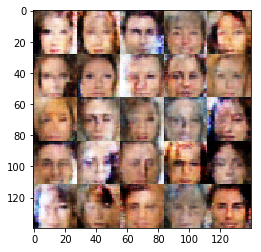

Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.4592
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.6593
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.8724
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 2.5860
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.8481
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.9185
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 2.6981


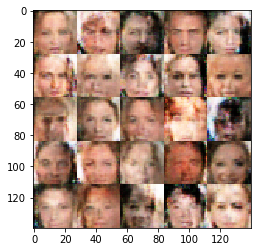

Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 2.9994
Epoch 1/1... Discriminator Loss: 1.5946... Generator Loss: 3.3926
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.9269
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 1.7618
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 2.1346
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 2.9796
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.8797
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.1890


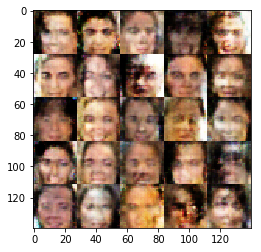

Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.7093
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 2.7297
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 2.1608
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 2.4754
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 2.2241
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.7229
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 2.8265
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 3.5679


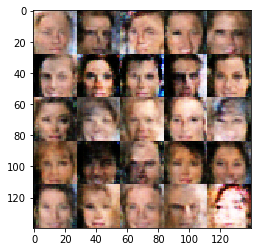

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 2.9511
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 2.8497
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 2.1140
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 1.5434
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.9153
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.7015
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 2.3354


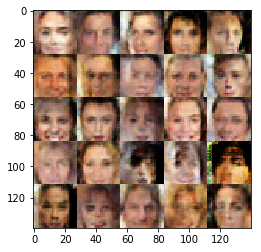

Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 2.0570
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 2.9462
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.9784
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.9474
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 2.3388
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 2.1515
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 2.4235
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 3.5749
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 2.8411
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.4206


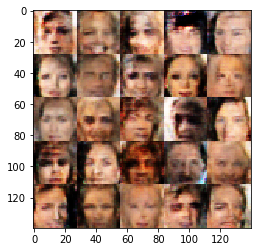

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 2.3772
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.2422
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 2.4386


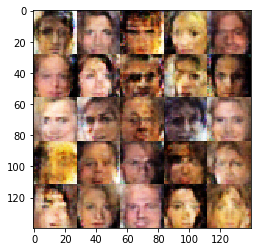

Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 2.9634
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 2.6930
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 2.7083
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 2.0090
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.3652
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.5486


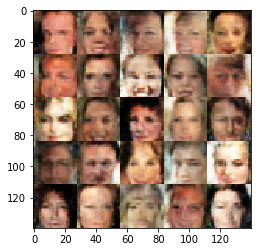

Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.6039
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.9124
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 2.0537
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 2.5918
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 2.0298
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.7503
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 2.0089
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.7825
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.6931


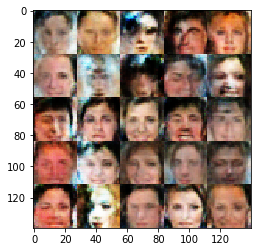

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 2.7406
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.9033
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 3.3104
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 2.0499
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.6979
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.8359
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.6355


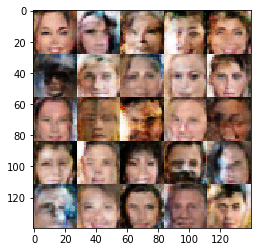

Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.6952
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.9255
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.6620
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 2.6410
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 2.2472


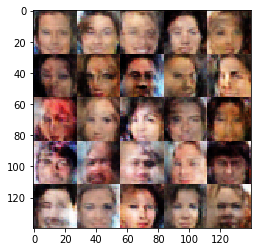

Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 2.8489
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 2.0231
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 4.1546
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 2.6755
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 2.4731
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.6356
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.6009
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.8499
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.6305


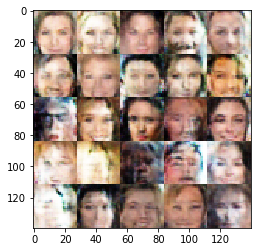

Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 2.0182
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.6881
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 2.6161
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.8268
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.6641
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.6966
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 2.0170


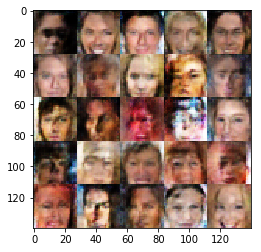

Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 3.4245
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 2.9566
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 3.3841
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 3.3514
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 2.3421
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.5496
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 2.2285
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.8941


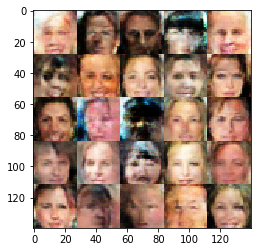

Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.9874
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.5145
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 2.2737
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 2.3925
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.9908
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 2.2109
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.4674


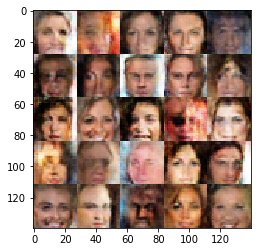

Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 2.0580
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 2.1595
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.9503
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.8593
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.4988
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.9459


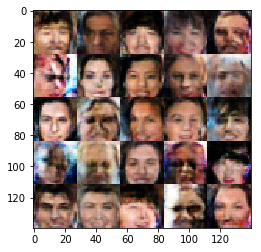

Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.5935
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 2.7118
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.7546
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 2.2139
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 2.7752
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.1985


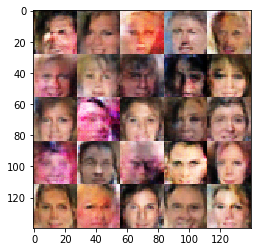

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 2.1247
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.6398
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 2.8486
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.5985
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.5675
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 2.5629
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.4286
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.0572


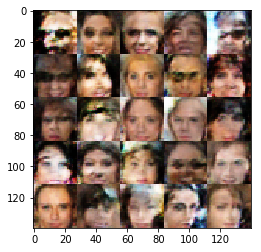

Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.5848
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.6570
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.4805
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 2.8155
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 2.2540


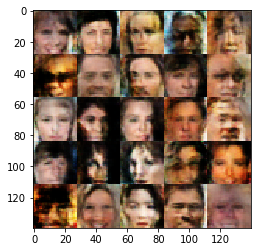

Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 2.1288
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.5037
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.9274
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.4682
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.4597
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 2.8002
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 2.3917
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 2.7524
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.5648


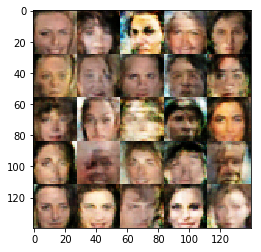

Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 2.4977
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 3.5115
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 3.1889
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.6601
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 2.6617
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.7778
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.4512


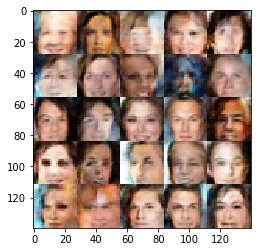

Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 2.8332
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 2.5252
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.7055
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.8068
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 2.2300
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.5238


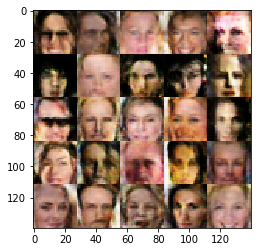

Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.3021
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 2.0904
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 2.3340
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 2.1152
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.5756
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.9856
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 2.0120
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.5538


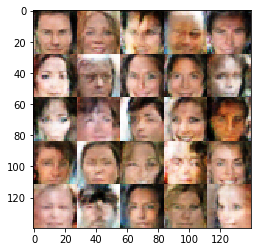

Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.4194
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 2.9119
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.9821
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 2.3402
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 2.4040
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.8477
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 2.8362
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.3886


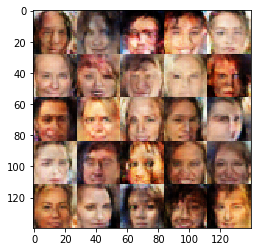

Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 3.2523
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.6324
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 3.5295
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.5860
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 2.3055
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 2.7482
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.3655


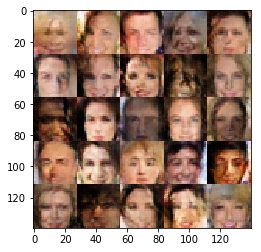

Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 2.4535
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.5539
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.4995
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.4085
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 2.2780
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 2.1164
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.7920
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 2.0930


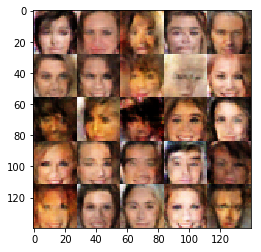

Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 2.5092
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.2947
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 2.7006
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.6514


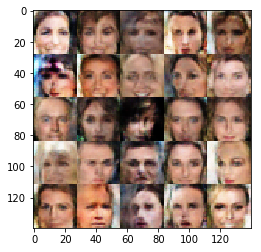

Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.5810
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 2.5968
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 2.2828
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 2.7482
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 2.1055
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 3.0089
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 2.7061
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.5924
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 2.3622


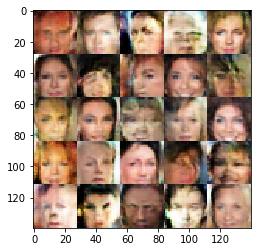

Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 2.1369
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.6538
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 2.2405
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.7118
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.8334
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 2.0998
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.8593


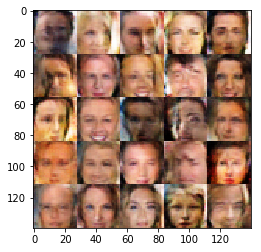

Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.4524
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 2.3059
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 3.1343
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 2.2224
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 2.2965
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.7046
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.2230
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 2.5663
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.7790


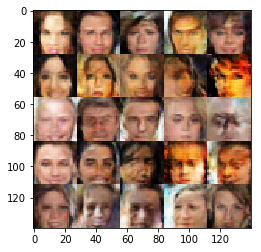

Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.7675
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.5986
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.7822
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 2.2682
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.1950
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.3482
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.7861


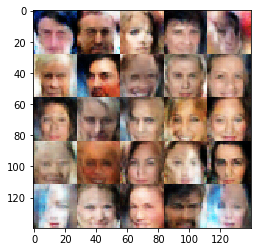

Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 2.2608
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 2.4231
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.7508


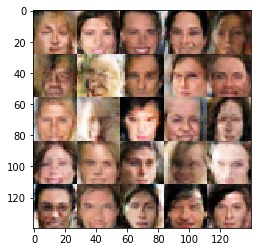

Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 1.9366
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 2.0074
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.6263
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.7112
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 2.7414
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 2.5502
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 2.3475
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.4205


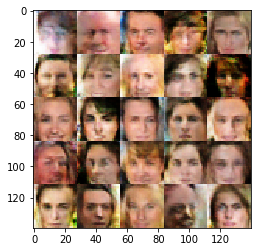

Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 2.7900
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 2.7196
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.6159
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.7857
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.3310
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.9684
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.6033


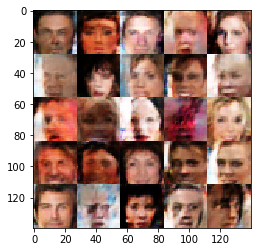

Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.6099
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 2.1733
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.4707
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.6432
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.9667
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.5044
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 2.0165
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.3405


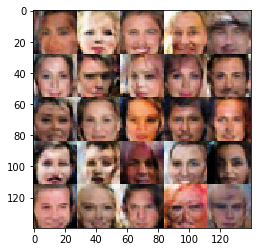

Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.7153
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 3.4008
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 2.0043
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 2.9200
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 2.2287
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 2.1915


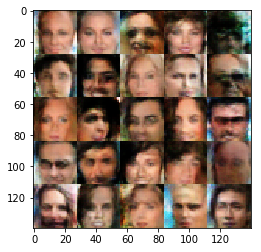

Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 3.1282
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.5099
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 1.1664
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.6460
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.3292


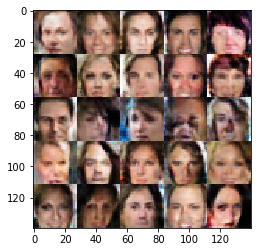

Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 2.1186
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.6060
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.7265
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.7655
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.7940


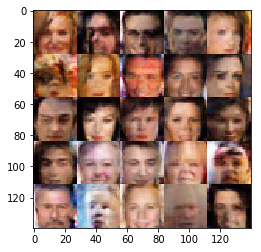

Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 2.1833
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.6591
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.7820
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 2.0210
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 2.4219
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.8751
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 2.1708


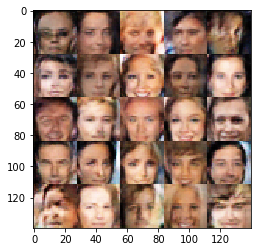

Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.6043
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.7488
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.4019


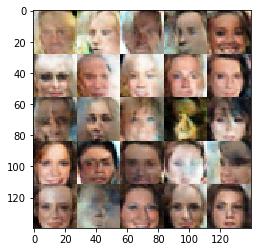

Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.6134
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.6199
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 1.9714
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 2.0539
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 2.1522


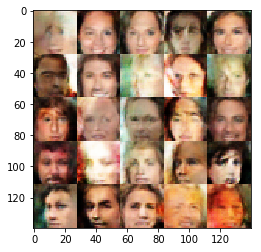

Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.8867
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.7915
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.7257
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.9179
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 2.4573
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 1.6516
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 2.1800


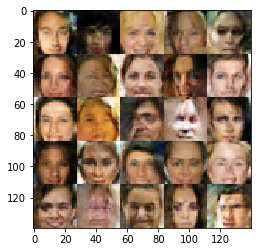

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 2.3917
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 2.0041
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.5792
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.3932
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.4150
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 2.0919
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 1.4610


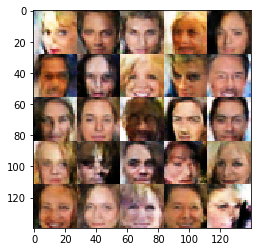

Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 2.0271
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.4732
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 2.0798
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 2.4333
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 2.1792
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 2.6024
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.7413


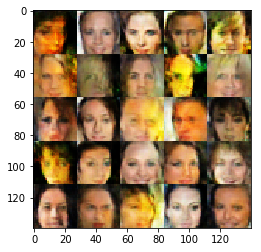

Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.6855
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 2.6443
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.4290
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.6144


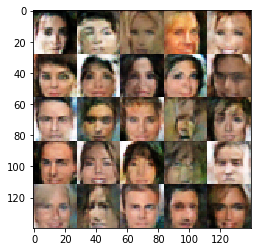

Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.6766
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 2.1917
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 2.1541


In [20]:

batch_size = 16
z_dim = 100
learning_rate = 0.0002


beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.